# Model Inference Exploration

This notebook explores model loading, tokenization, and basic inference capabilities.

- Load and test base code model (baseline)
- Test FIM (Fill-in-the-Middle) autocomplete format
- Evaluate using standard prompts from shared module
- Measure inference latency and performance
- Establish baseline metrics for comparison with trained models

In [15]:
import sys
import torch
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [16]:
# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to path:", project_root)

Project root added to path: /Users/tgdimas1/Projs/python/code_complete


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.config import MODEL_NAME, MODELS_DIR, EVAL_DIR, DATASETS_DIR, UNIFIED_DIR
from src.data_processing import build_autocomplete_prompt, tokenizer_supports_fim
from src.evaluation import (
    GENERIC_EVAL_PROMPTS,
    CDK_EVAL_PROMPTS,
    evaluate_model_on_prompts,
    print_evaluation_summary,
    generate_code
)

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

## Configuration

In [ ]:
# Model configuration
MODELS_DIR.mkdir(exist_ok=True)
EVAL_DIR.mkdir(exist_ok=True)

print(f"Model: {MODEL_NAME}")
print(f"Models directory: {MODELS_DIR}")
print(f"Evaluation directory: {EVAL_DIR}")

## Load Model and Tokenizer

In [ ]:
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True,
    local_files_only=True,
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Loading model for {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16 if device != torch.device("cpu") else torch.float32,
    local_files_only=True,
)
model = model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Check FIM support
fim_supported = tokenizer_supports_fim(tokenizer)
print(f"\nFIM tokens supported: {fim_supported}")
if fim_supported:
    print("Model supports Fill-in-the-Middle autocomplete")
else:
    print("Model does not support FIM - will use prefix-only completion")

## Test FIM Autocomplete Format

Test the FIM prompt building using the shared module.

In [22]:
# Test FIM prompt building
print("Testing FIM Prompt Format")
print("=" * 60)

prefix = """def calculate_sum(a, b):
    \"\"\"Add two numbers and return the result.\"\"\"\n    """
suffix = "\n    return result"

fim_prompt = build_autocomplete_prompt(prefix, suffix, tokenizer)
print("\nFIM Prompt (with suffix):")
print(fim_prompt)
print("\n" + "=" * 60)

# Test without suffix (prefix-only)
prefix_only_prompt = build_autocomplete_prompt(prefix, None, tokenizer)
print("\nPrefix-only Prompt (no suffix):")
print(prefix_only_prompt)
print("\n" + "=" * 60)

# Test another example
prefix2 = """class DataProcessor:
    def __init__(self, config):
        self.config = config
    
    def process(self, data):
        # Process the data
        """
suffix2 = "\n        return processed_data"

fim_prompt2 = build_autocomplete_prompt(prefix2, suffix2, tokenizer)
print("\nFIM Prompt Example 2:")
print(fim_prompt2[:300] + "...")

Testing FIM Prompt Format

FIM Prompt (with suffix):
<|fim_prefix|>def calculate_sum(a, b):
    """Add two numbers and return the result."""
    <|fim_suffix|>
    return result<|fim_middle|>


Prefix-only Prompt (no suffix):
def calculate_sum(a, b):
    """Add two numbers and return the result."""
    


FIM Prompt Example 2:
<|fim_prefix|>class DataProcessor:
    def __init__(self, config):
        self.config = config
    
    def process(self, data):
        # Process the data
        <|fim_suffix|>
        return processed_data<|fim_middle|>...


## Evaluate on Generic Code Generation Prompts

Use standard evaluation prompts from the shared module.

In [21]:
print("Evaluating on generic code generation prompts...")
print("=" * 60)

generic_results = evaluate_model_on_prompts(
    model=model,
    tokenizer=tokenizer,
    prompts=GENERIC_EVAL_PROMPTS,
    device=str(device),
    max_tokens=100
)

print_evaluation_summary(generic_results)

# Show detailed results
print("\n" + "=" * 60)
print("Detailed Results:")
print("=" * 60)
for result in generic_results:
    print(f"\n{result['name']}:")
    print(f"  Prompt: {result['prompt'][:100]}...")
    print()
    print(f"  Generated: {result['generated'][:150]}...")
    print()
    print(f"  Syntax valid: {'Yes' if result['syntax_valid'] else 'No'}")
    print(f"  Latency: {result['latency_ms']:.1f}ms")
    print(f"  Keywords found: {len(result['keywords_found'])}/{len(result['keywords_expected'])}")
    if result['keywords_found']:
        print(f"    {result['keywords_found']}")
    print("" + "-" * 60 + "\n")

Evaluating on generic code generation prompts...
EVALUATION SUMMARY
Total samples: 3
Syntax valid: 3/3 (100.0%)

Latency:
  Mean: 2387.5ms
  P50:  2103.9ms
  P95:  3737.2ms

Keyword match rate: 100.0%

Detailed Results:
✓ Factorial Function: 3737ms, keywords: 5/5
✓ List Filter: 1321ms, keywords: 5/5
✓ String Reversal: 2104ms, keywords: 4/4

Detailed Results:

Factorial Function:
  Prompt: # Write Python code for the following docstring
"""
Calculate the factorial of a number using recurs...

  Generated: def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n - 1)

# Test the function
print(factorial(5))  # Output: 12...

  Syntax valid: Yes
  Latency: 3737.2ms
  Keywords found: 5/5
    ['def', 'factorial', 'if', 'return', 'n']
------------------------------------------------------------


List Filter:
  Prompt: # Write Python code for the following docstring
"""
Filter a list to keep only even numbers.
Args:
 ...

  Generated: def filter_even_numbers

## Evaluate on CDK-Specific Prompts

In [24]:
print("\nEvaluating on CDK-specific prompts...")
print("=" * 60)

cdk_results = evaluate_model_on_prompts(
    model=model,
    tokenizer=tokenizer,
    prompts=CDK_EVAL_PROMPTS,
    device=str(device),
    max_tokens=100
)

print_evaluation_summary(cdk_results)

# Show detailed results
print("\n" + "=" * 60)
print("Detailed CDK Results:")
print("=" * 60)
for result in cdk_results:
    print(f"\n{result['name']}:")
    print(f"  Prompt: {result['prompt'][:80]}...")
    print(f"  Generated: {result['generated'][:150]}...")
    print(f"  Syntax valid: {'Yes' if result['syntax_valid'] else 'No'}")
    print(f"  Latency: {result['latency_ms']:.1f}ms")
    print(f"  Keywords found: {len(result['keywords_found'])}/{len(result['keywords_expected'])}")
    if result['keywords_found']:
        print(f"    {result['keywords_found']}")


Evaluating on CDK-specific prompts...
EVALUATION SUMMARY
Total samples: 2
Syntax valid: 1/2 (50.0%)

Latency:
  Mean: 4845.2ms
  P50:  5727.6ms
  P95:  5727.6ms

Keyword match rate: 40.0%

Detailed Results:
✗ S3 Bucket with Encryption: 5728ms, keywords: 2/5
✓ Lambda Function: 3963ms, keywords: 2/5

Detailed CDK Results:

S3 Bucket with Encryption:
  Prompt: # Write Python code for the following docstring
"""
Create an S3 bucket with:
- ...
  Generated: import boto3
import botocore
import os
import sys
import logging
from botocore.exceptions import ClientError


def create_bucket(bucket_name, region=N...
  Syntax valid: No
  Latency: 5727.6ms
  Keywords found: 2/5
    ['s3', 'Bucket']

Lambda Function:
  Prompt: # Write Python code for the following docstring
"""
Create a Lambda function wit...
  Generated: import json
import os

def lambda_handler(event, context):
    # Get the environment variable
    my_variable = os.environ.get('MY_VARIABLE')
    
   ...
  Syntax valid: Yes
  Laten

## Test on Samples from Prepared Dataset

Test the model on real samples from both task types: autocomplete_fim and comment2code.

In [26]:
# Load unified dataset
from src.data_processing import load_train_val_data

print("Loading unified dataset...")
train_data, val_data = load_train_val_data(str(UNIFIED_DIR))
print(f"Loaded {len(train_data)} training samples, {len(val_data)} validation samples")

# Find one sample of each task type
fim_sample = None
c2c_sample = None

for sample in train_data:
    if sample.get('task') == 'autocomplete_fim' and fim_sample is None:
        fim_sample = sample
    elif sample.get('task') == 'comment2code' and c2c_sample is None:
        c2c_sample = sample
    
    if fim_sample and c2c_sample:
        break

print(f"\nFound FIM sample: {fim_sample is not None}")
print(f"Found comment2code sample: {c2c_sample is not None}")

print("\n" + "=" * 60)
print("FIM Sample Preview:")
if fim_sample:
    print(f"Language: {fim_sample.get('language', 'unknown')}")
    print(f"Prefix (first 100 chars): {fim_sample.get('prefix', '')[:100]}...")
    print(f"Suffix (first 50 chars): {fim_sample.get('suffix', '')[:50]}...")
    print(f"Expected middle (first 100 chars): {fim_sample.get('middle', '')[:100]}...")
else:
    print("No FIM sample found")

print("\n" + "=" * 60)

print("Comment-to-Code Sample Preview:")
if c2c_sample:
    print(f"Language: {c2c_sample.get('language', 'unknown')}")
    print(f"Prompt:\n{c2c_sample.get('prompt', '')}")
    print(f"Expected completion (first 100 chars): {c2c_sample.get('completion', '')[:100]}...")
else:
    print("No comment2code sample found")
print("\n" + "=" * 60)


Loading unified dataset...
Loaded 36913 training samples, 4147 validation samples

Found FIM sample: True
Found comment2code sample: True

FIM Sample Preview:
Language: python
Prefix (first 100 chars): def resolve(self, key):
        """Looks up a variable like `__getitem__` or `get` but returns an
  ...
Suffix (first 50 chars): 
            rv = self.resolve_or_missing(key)
   ...
Expected middle (first 100 chars): 
        if self._legacy_resolve_mode:
            rv = resolve_or_missing(self, key)
        else:...

Comment-to-Code Sample Preview:
Language: javascript
Prompt:
// Write TypeScript/JavaScript code for the following comment
/**
If none of index and id and name used, return all components with mainType.
@param {Object} condition
@param {string} condition.mainType
@param {string} [condition.subType] If ignore, only query by mainType
@param {number|Array.<number>} [condition.index] Either input index or id or name.
@param {string|Array.<string>} [condition.id] Either input 

### Test 1: Autocomplete FIM Task

In [28]:
if fim_sample:
    print("Testing FIM Autocomplete Task")
    print("=" * 60)
    
    # Extract structured fields
    prefix = fim_sample.get('prefix', '')
    suffix = fim_sample.get('suffix', '')
    expected_middle = fim_sample.get('middle', '')
    language = fim_sample.get('language', 'unknown')
    sample_id = fim_sample.get('id', 'N/A')
    
    print(f"\nSample ID: {sample_id}")
    print(f"Language: {language}")
    print(f"\nPrefix (first 150 chars):\n{prefix[:150]}...")
    print(f"\nSuffix (first 100 chars):\n{suffix[:100]}...")
    print(f"\nExpected middle (first 150 chars):\n{expected_middle[:150]}...")
    
    # Build FIM prompt using shared function
    fim_prompt = build_autocomplete_prompt(prefix, suffix, tokenizer)
    
    # Generate completion
    print("\n" + "-" * 60)
    print("Generating completion...")
    generated, latency = generate_code(
        model=model,
        tokenizer=tokenizer,
        prompt=fim_prompt,
        max_tokens=100,
        device=str(device)
    )
    
    print(f"\nGenerated middle (first 200 chars):\n{generated[:200]}...")
    print(f"\nLatency: {latency:.1f}ms")
    
    # Check if generation is reasonable
    if language == 'python':
        from src.evaluation import validate_python_syntax
        # Reconstruct full code for syntax check
        full_code = prefix + generated + suffix
        is_valid = validate_python_syntax(full_code)
        print(f"Syntax valid: {'Yes' if is_valid else 'No'}")
    
    print("=" * 60)
else:
    print("No FIM sample found in dataset")

Testing FIM Autocomplete Task

Sample ID: 02b86ec613c0e4ac6df7fb2e8a6d29a7:fim:2
Language: python

Prefix (first 150 chars):
def resolve(self, key):
        """Looks up a variable like `__getitem__` or `get` but returns an
        :class:`Undefined` object with the name of t...

Suffix (first 100 chars):

            rv = self.resolve_or_missing(key)
        if rv is missing:
            return self.env...

Expected middle (first 150 chars):

        if self._legacy_resolve_mode:
            rv = resolve_or_missing(self, key)
        else:...

------------------------------------------------------------
Generating completion...

Generated middle (first 200 chars):

        rv = self.get(key, missing)...

Latency: 1048.8ms
Syntax valid: Yes


### Test 2: Comment-to-Code Task

In [29]:
if c2c_sample:
    print("Testing Comment-to-Code Task")
    print("=" * 60)
    
    # Extract structured fields
    prompt = c2c_sample.get('prompt', '')
    expected_completion = c2c_sample.get('completion', '')
    language = c2c_sample.get('language', 'unknown')
    sample_id = c2c_sample.get('id', 'N/A')
    
    print(f"\nSample ID: {sample_id}")
    print(f"Language: {language}")
    print(f"\nPrompt:\n{prompt}")
    print(f"\nExpected completion (first 200 chars):\n{expected_completion[:200]}...")
    
    # Generate completion
    print("\n" + "-" * 60)
    print("Generating completion...")
    generated, latency = generate_code(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_tokens=150,
        device=str(device)
    )
    
    print(f"\nGenerated completion (first 200 chars):\n{generated[:200]}...")
    print(f"\nLatency: {latency:.1f}ms")
    
    # Check syntax validity
    if language == 'python':
        from src.evaluation import validate_python_syntax
        # Combine prompt and generated code for syntax check
        full_code = prompt + generated
        is_valid = validate_python_syntax(full_code)
        print(f"Syntax valid: {'Yes' if is_valid else 'No'}")
    elif language in ['typescript', 'javascript']:
        from src.evaluation import validate_typescript_syntax
        full_code = prompt + generated
        is_valid = validate_typescript_syntax(full_code)
        print(f"Syntax valid: {'Yes' if is_valid else 'No'}")
    
    print("=" * 60)
else:
    print("No comment2code sample found in dataset")

Testing Comment-to-Code Task

Sample ID: 4daf2b17e598e35b68e872086fb93894:c2c
Language: javascript

Prompt:
// Write TypeScript/JavaScript code for the following comment
/**
If none of index and id and name used, return all components with mainType.
@param {Object} condition
@param {string} condition.mainType
@param {string} [condition.subType] If ignore, only query by mainType
@param {number|Array.<number>} [condition.index] Either input index or id or name.
@param {string|Array.<string>} [condition.id] Either input index or id or name.
@param {string|Array.<string>} [condition.name] Either input index or id or name.
@return {Array.<module:echarts/model/Component>}
*/


Expected completion (first 200 chars):
function (condition) {
        var mainType = condition.mainType;
        if (!mainType) {
            return [];
        }

        var index = condition.index;
        var id = condition.id;
       ...

------------------------------------------------------------
Generating comp

### Data Format Inspection

Show the structured format of both sample types.

In [30]:
print("Structured Data Format Examples")
print("=" * 60)

if fim_sample:
    print("\n1. FIM Sample Structure:")
    print(json.dumps({
        "task": fim_sample.get('task'),
        "language": fim_sample.get('language'),
        "id": fim_sample.get('id'),
        "prefix": fim_sample.get('prefix', '')[:80] + "...",
        "suffix": fim_sample.get('suffix', '')[:80] + "...",
        "middle": fim_sample.get('middle', '')[:80] + "...",
        "text": "(optional field)" if 'text' in fim_sample else "(not present)"
    }, indent=2))

if c2c_sample:
    print("\n2. Comment-to-Code Sample Structure:")
    print(json.dumps({
        "task": c2c_sample.get('task'),
        "language": c2c_sample.get('language'),
        "id": c2c_sample.get('id'),
        "prompt": c2c_sample.get('prompt', '')[:100] + "...",
        "completion": c2c_sample.get('completion', '')[:100] + "...",
        "text": "(optional field)" if 'text' in c2c_sample else "(not present)"
    }, indent=2))

print("\n" + "=" * 60)
print("\nKey Features of New Format:")
print("  ✓ Task-specific structured fields (prefix/suffix/middle OR prompt/completion)")
print("  ✓ Deterministic IDs for reproducibility")
print("  ✓ Task and language metadata")
print("  ✓ Optional 'text' field for backward compatibility")

Structured Data Format Examples

1. FIM Sample Structure:
{
  "task": "autocomplete_fim",
  "language": "python",
  "id": "02b86ec613c0e4ac6df7fb2e8a6d29a7:fim:2",
  "prefix": "def resolve(self, key):\n        \"\"\"Looks up a variable like `__getitem__` or `ge...",
  "suffix": "\n            rv = self.resolve_or_missing(key)\n        if rv is missing:\n       ...",
  "middle": "\n        if self._legacy_resolve_mode:\n            rv = resolve_or_missing(self,...",
  "text": "(optional field)"
}

2. Comment-to-Code Sample Structure:
{
  "task": "comment2code",
  "language": "javascript",
  "id": "4daf2b17e598e35b68e872086fb93894:c2c",
  "prompt": "// Write TypeScript/JavaScript code for the following comment\n/**\nIf none of index and id and name u...",
  "completion": "function (condition) {\n        var mainType = condition.mainType;\n        if (!mainType) {\n         ...",
  "text": "(optional field)"
}


Key Features of New Format:
  ✓ Task-specific structured fields (prefix/suffi

## Latency Benchmarking

Benchmark inference latency with different prompt lengths.

In [32]:
# Benchmark with different prompt lengths
benchmark_prompts = [
    "def hello():",  # Short
    "def process_data(data):\n    # Process input\n    result = []",  # Medium
    """class DataProcessor:
    def __init__(self, config):
        self.config = config
    
    def process(self, data):
        # Complex processing logic
        for item in data:""",  # Long
]

print("Benchmarking inference latency...")
print("=" * 60)

latencies = []
num_runs = 5

for prompt in benchmark_prompts:
    for _ in range(num_runs):
        _, latency = generate_code(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            max_tokens=15,
            device=str(device)
        )
        latencies.append(latency)

# Calculate statistics
latencies_sorted = sorted(latencies)
p50 = latencies_sorted[len(latencies_sorted)//2]
p95 = latencies_sorted[int(len(latencies_sorted)*0.95)]

print("\nLatency Benchmark Results:")
print(f"  Mean: {np.mean(latencies):.1f}ms")
print(f"  Median (P50): {p50:.1f}ms")
print(f"  P95: {p95:.1f}ms")
print(f"  Min: {min(latencies):.1f}ms")
print(f"  Max: {max(latencies):.1f}ms")
print(f"  Std Dev: {np.std(latencies):.1f}ms")

# Check against requirements (P50 ≤ 300ms, P95 ≤ 800ms)
print("\nRequirements Check:")
p50_pass = p50 <= 300
p95_pass = p95 <= 800
print(f"  P50 ≤ 300ms: {'PASS' if p50_pass else 'FAIL'} ({p50:.1f}ms)")
print(f"  P95 ≤ 800ms: {'PASS' if p95_pass else 'FAIL'} ({p95:.1f}ms)")

Benchmarking inference latency...

Latency Benchmark Results:
  Mean: 802.5ms
  Median (P50): 766.6ms
  P95: 1206.7ms
  Min: 736.3ms
  Max: 1206.7ms
  Std Dev: 112.0ms

Requirements Check:
  P50 ≤ 300ms: FAIL (766.6ms)
  P95 ≤ 800ms: FAIL (1206.7ms)


## Visualize Performance Metrics

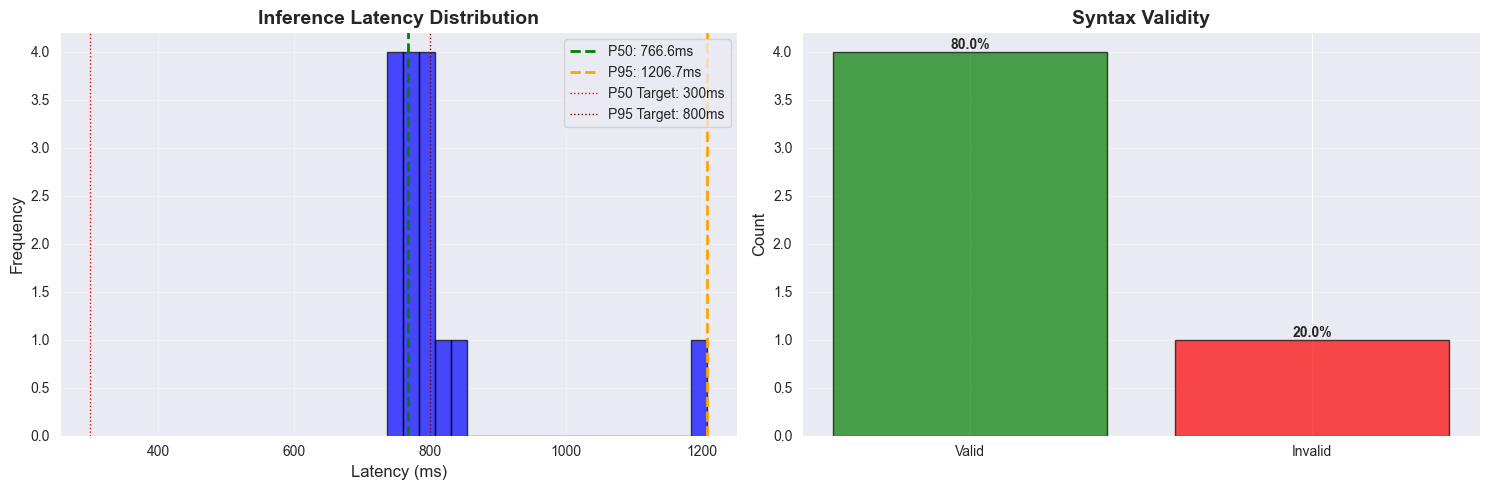


Performance visualization saved to: /Users/tgdimas1/Projs/python/code_complete/evaluation/baseline_m0_performance.png


In [33]:
# Visualize latency distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Latency distribution
axes[0].hist(latencies, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(p50, color='green', linestyle='--', linewidth=2, label=f'P50: {p50:.1f}ms')
axes[0].axvline(p95, color='orange', linestyle='--', linewidth=2, label=f'P95: {p95:.1f}ms')
axes[0].axvline(300, color='red', linestyle=':', linewidth=1, label='P50 Target: 300ms')
axes[0].axvline(800, color='darkred', linestyle=':', linewidth=1, label='P95 Target: 800ms')
axes[0].set_xlabel('Latency (ms)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Inference Latency Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Syntax validity comparison
all_results = generic_results + cdk_results
valid_count = sum(1 for r in all_results if r['syntax_valid'])
invalid_count = len(all_results) - valid_count

axes[1].bar(['Valid', 'Invalid'], [valid_count, invalid_count], 
           color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Syntax Validity', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
total = len(all_results)
axes[1].text(0, valid_count, f'{100*valid_count/total:.1f}%', 
            ha='center', va='bottom', fontweight='bold')
axes[1].text(1, invalid_count, f'{100*invalid_count/total:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(EVAL_DIR / 'baseline_m0_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPerformance visualization saved to: {EVAL_DIR / 'baseline_m0_performance.png'}")

## Save Baseline Results

Save M0 (base model) results for comparison with trained models (M1, M2).

In [34]:
from src.evaluation import summarize_evaluation_results

# Prepare baseline results
baseline_results = {
    "model_name": MODEL_NAME,
    "model_type": "M0_baseline",
    "fim_supported": fim_supported,
    "generic_evaluation": {
        "summary": summarize_evaluation_results(generic_results),
        "detailed_results": generic_results
    },
    "cdk_evaluation": {
        "summary": summarize_evaluation_results(cdk_results),
        "detailed_results": cdk_results
    },
    "latency_benchmark": {
        "mean_ms": float(np.mean(latencies)),
        "median_ms": float(p50),
        "p95_ms": float(p95),
        "min_ms": float(min(latencies)),
        "max_ms": float(max(latencies)),
        "std_dev_ms": float(np.std(latencies)),
        "num_samples": len(latencies),
        "p50_requirement_met": p50 <= 300,
        "p95_requirement_met": p95 <= 800
    },
    "overall_metrics": {
        "total_evaluations": len(all_results),
        "syntax_valid_count": valid_count,
        "syntax_validity_percent": 100 * valid_count / len(all_results)
    }
}

# Save to JSON
results_file = EVAL_DIR / "baseline_m0_results.json"
with open(results_file, 'w') as f:
    json.dump(baseline_results, f, indent=2)

print(f"\nBaseline results saved to: {results_file}")
print("\n" + "=" * 60)
print("Summary:")
print("=" * 60)
print(f"Model: {MODEL_NAME}")
print(f"FIM Support: {'Yes' if fim_supported else 'No'}")
print(f"\nGeneric Evaluation:")
print(f"  Syntax Validity: {baseline_results['generic_evaluation']['summary']['syntax_validity_percent']:.1f}%")
print(f"  Mean Latency: {baseline_results['generic_evaluation']['summary']['mean_latency_ms']:.1f}ms")
print(f"\nCDK Evaluation:")
print(f"  Syntax Validity: {baseline_results['cdk_evaluation']['summary']['syntax_validity_percent']:.1f}%")
print(f"  Mean Latency: {baseline_results['cdk_evaluation']['summary']['mean_latency_ms']:.1f}ms")
print(f"\nLatency Benchmark:")
print(f"  P50: {p50:.1f}ms (target: ≤300ms) {'✓' if p50_pass else '✗'}")
print(f"  P95: {p95:.1f}ms (target: ≤800ms) {'✓' if p95_pass else '✗'}")
print("\nBaseline (M0) evaluation complete!")


Baseline results saved to: /Users/tgdimas1/Projs/python/code_complete/evaluation/baseline_m0_results.json

Summary:
Model: Qwen/Qwen2.5-Coder-7B
FIM Support: Yes

Generic Evaluation:
  Syntax Validity: 100.0%
  Mean Latency: 2387.5ms

CDK Evaluation:
  Syntax Validity: 50.0%
  Mean Latency: 4845.2ms

Latency Benchmark:
  P50: 766.6ms (target: ≤300ms) ✗
  P95: 1206.7ms (target: ≤800ms) ✗

Baseline (M0) evaluation complete!


## Test FIM Autocomplete with Real Examples

Test the model's autocomplete capability with FIM format using real training data.

In [35]:
# Load some FIM samples from the unified dataset to test
unified_data_path = project_root / "datasets" / "unified" / "train.jsonl"

if unified_data_path.exists():
    print("Loading FIM samples from unified dataset...")
    fim_samples = []
    with open(unified_data_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= 100:  # Load first 100 samples
                break
            sample = json.loads(line)
            if sample.get('task') == 'autocomplete_fim':
                fim_samples.append(sample)
    
    print(f"Loaded {len(fim_samples)} FIM samples")
    
    if fim_samples and fim_supported:
        print("\nTesting FIM Autocomplete with Real Training Data")
        print("=" * 60)
        
        # Test with 3 random samples
        import random
        test_samples = random.sample(fim_samples, min(3, len(fim_samples)))
        
        for idx, sample in enumerate(test_samples, 1):
            print(f"\nExample {idx}:")
            print(f"Language: {sample.get('language', 'unknown')}")
            print(f"ID: {sample.get('id', 'N/A')}")
            
            # Use structured fields
            prefix = sample.get('prefix', '')
            suffix = sample.get('suffix', '')
            expected_middle = sample.get('middle', '')
            
            print(f"\nPrefix (first 100 chars): {prefix[:100]}...")
            print(f"Suffix (first 50 chars): {suffix[:50]}...")
            print(f"Expected middle (first 100 chars): {expected_middle[:100]}...")
            
            # Build FIM prompt
            fim_prompt = build_autocomplete_prompt(prefix, suffix, tokenizer)
            
            # Generate
            generated, latency = generate_code(
                model, tokenizer, fim_prompt, 
                max_tokens=50, 
                device=str(device)
            )
            
            print(f"\nGenerated (first 100 chars): {generated[:100]}...")
            print(f"Latency: {latency:.1f}ms")
            print("-" * 60)
        
        print("\n" + "=" * 60)
    elif not fim_supported:
        print("\nSkipping FIM tests (model does not support FIM tokens)")
    else:
        print("\nNo FIM samples found in dataset")
else:
    print(f"\nUnified dataset not found at {unified_data_path}")
    print("Run notebook 01 first to generate the dataset")
    
    # Fallback to manual examples
    if fim_supported:
        print("\nTesting with manual FIM examples...")
        print("=" * 60)
        
        # Example 1: Simple function
        prefix1 = "def factorial(n):\n    if n <= 1:\n        return 1\n    else:\n        "
        suffix1 = ""
        
        fim_prompt1 = build_autocomplete_prompt(prefix1, suffix1, tokenizer)
        generated1, latency1 = generate_code(model, tokenizer, fim_prompt1, max_tokens=30, device=str(device))
        
        print("\nExample 1: Factorial function")
        print(f"Prefix: {prefix1}")
        print(f"Generated: {generated1}")
        print(f"Latency: {latency1:.1f}ms")
        
        # Example 2: List comprehension
        prefix2 = "numbers = [1, 2, 3, 4, 5]\neven_numbers = ["
        suffix2 = "]"
        
        fim_prompt2 = build_autocomplete_prompt(prefix2, suffix2, tokenizer)
        generated2, latency2 = generate_code(model, tokenizer, fim_prompt2, max_tokens=20, device=str(device))
        
        print("\n" + "-" * 60)
        print("Example 2: List comprehension")
        print(f"Prefix: {prefix2}")
        print(f"Suffix: {suffix2}")
        print(f"Generated: {generated2}")
        print(f"Latency: {latency2:.1f}ms")
        
        print("\n" + "=" * 60)

Loading FIM samples from unified dataset...
Loaded 60 FIM samples

Testing FIM Autocomplete with Real Training Data

Example 1:
Language: python
ID: 606a1169afcfbef7ff96aa4ce3542b30:fim:2

Prefix (first 100 chars): def _get_combined_index(indexes, intersect=False, sort=False):
    """
    Return the union or inter...
Suffix (first 50 chars): 
        index = indexes[0]
    elif intersect:
  ...
Expected middle (first 100 chars): 
    ----------
    indexes : list of Index or list objects
        When intersect=True, do not acce...

Generated (first 100 chars): 
    ----------
    indexes : list of Index
    intersect : bool, default False
        Return the i...
Latency: 3359.3ms
------------------------------------------------------------

Example 2:
Language: python
ID: 9ad02ac8ef3f30fcd7e004a580df7575:fim:1

Prefix (first 100 chars): def refresh_datasources(
            self,
            datasource_name=None,
            merge_flag=...
Suffix (first 50 chars): 
        if not dataso

## Inspect Data Format

Show examples of the new structured data format.

In [38]:
if unified_data_path.exists():
    print("New Structured Data Format Examples")
    print("=" * 60)
    
    with open(unified_data_path, 'r') as f:
        # Show one FIM sample
        for line in f:
            sample = json.loads(line)
            if sample.get('task') == 'autocomplete_fim':
                print("\n1. FIM Sample Structure:")
                print(json.dumps({
                    "task": sample.get('task'),
                    "language": sample.get('language'),
                    "id": sample.get('id'),
                    "prefix": sample.get('prefix', '')[:80] + "...",
                    "suffix": sample.get('suffix', '')[:80] + "...",
                    "middle": sample.get('middle', '')[:80] + "...",
                    "text": sample.get('text', '')[:100] + "..." if 'text' in sample else "(optional)"
                }, indent=2))
                break
    
    with open(unified_data_path, 'r') as f:
        # Show one comment2code sample
        for line in f:
            sample = json.loads(line)
            if sample.get('task') == 'comment2code':
                print("\n2. Comment-to-Code Sample Structure:")
                print(json.dumps({
                    "task": sample.get('task'),
                    "language": sample.get('language'),
                    "id": sample.get('id'),
                    "prompt": sample.get('prompt', '')[:100] + "...",
                    "completion": sample.get('completion', '')[:100] + "...",
                    "text": sample.get('text', '')[:100] + "..." if 'text' in sample else "(optional)"
                }, indent=2))
                break
    
    print("\n" + "=" * 60)
else:
    print("Dataset not found. Run notebook 01 to generate data.")

New Structured Data Format Examples

1. FIM Sample Structure:
{
  "task": "autocomplete_fim",
  "language": "python",
  "id": "02b86ec613c0e4ac6df7fb2e8a6d29a7:fim:2",
  "prefix": "def resolve(self, key):\n        \"\"\"Looks up a variable like `__getitem__` or `ge...",
  "suffix": "\n            rv = self.resolve_or_missing(key)\n        if rv is missing:\n       ...",
  "middle": "\n        if self._legacy_resolve_mode:\n            rv = resolve_or_missing(self,...",
  "text": "<|fim_prefix|>def resolve(self, key):\n        \"\"\"Looks up a variable like `__getitem__` or `get` but..."
}

2. Comment-to-Code Sample Structure:
{
  "task": "comment2code",
  "language": "javascript",
  "id": "4daf2b17e598e35b68e872086fb93894:c2c",
  "prompt": "// Write TypeScript/JavaScript code for the following comment\n/**\nIf none of index and id and name u...",
  "completion": "function (condition) {\n        var mainType = condition.mainType;\n        if (!mainType) {\n         ...",
  "text": "// W